In [54]:
from pathlib import Path
from math import isnan, nan

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats import linregress

import mesa_reader as mr
import mesaPlot as mp
#import tulips as tp

import sys
sys.path.append('..')
from src.util import CODE_ROOT, DATA_ROOT, MESA_DATA_ROOT

plt.style.use('./plotstyle.mplstyle')

In [2]:
Z_SUN = 0.017

In [ ]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        try:
            m, p, w = model_folder.name.replace('d', 'e').split('_')
            w = float(w.lstrip('w'))
            p = f'{float(p.lstrip("p")):.2f}'      
        except ValueError:
            m, w = model_folder.name.replace('d', 'e').split('_')   
            w = float(w.lstrip('w'))
            p = (2*np.pi/w) / (60*60*24)
        m = f'{float(m.lstrip("m")):.1f}'
    
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [8]:
def load_models(project_folder):
    model_folders = list(project_folder.glob('*_md*_m*_zsundiv*_*y0_*dy'))
    _model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
    model_dicts = dict()
    for dicts in _model_dicts:
        for m in dicts.keys():
            if m not in model_dicts.keys():
                model_dicts[m] = dicts[m]
    return model_dicts

In [9]:
project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/09_ZdivZsun_5d-4'
model_dicts_00005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/08_ZdivZsun_5d-3'
model_dicts_0005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/07_ZdivZsun_2d-2'
model_dicts_002zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/06_ZdivZsun_5d-2'
model_dicts_005zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1'
model_dicts_01zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1'
model_dicts_02zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/02_ZdivZsun_4d-1'
model_dicts_04zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/03_ZdivZsun_6d-1'
model_dicts_06zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1'
model_dicts_08zsun = load_models(project_folder)

###

project_folder = MESA_DATA_ROOT/'sse_enhanced_w_proof_of_concept/05_ZdivZsun_1d0'
model_dicts_10zsun = load_models(project_folder)


In [11]:
all_model_dicts = {
    '0.0005': model_dicts_00005zsun,
    '0.005': model_dicts_0005zsun,
    '0.02': model_dicts_002zsun,
    '0.05': model_dicts_005zsun,
    '0.1': model_dicts_01zsun,
    '0.2': model_dicts_02zsun,
    '0.4': model_dicts_04zsun,
    '0.6': model_dicts_06zsun,
    '0.8': model_dicts_08zsun,
    '1.0': model_dicts_10zsun
}

## Lifetimes

In [12]:
z_keys = sorted(list(all_model_dicts.keys()))

In [28]:
all_model_dicts

{'0.0005': {'70.0': {'0.90': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/09_ZdivZsun_5d-4/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p9.000d-01_w8.080d-05'),
   '0.70': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/09_ZdivZsun_5d-4/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p7.000d-01_w1.039d-04'),
   '4.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/09_ZdivZsun_5d-4/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d+00_w1.818d-05'),
   '3.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/09_ZdivZsun_5d-4/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p3.000d+00_w2.424d-05'),
   '2.00': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/09_ZdivZsun_5d-4/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p2.000d+00_w3.636d-05'),
   '2.30': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/09_ZdivZsun

In [87]:
def get_h_zdict(args):
    z_key, model_dict = args
    lifetimes = dict()
    for m in model_dict.keys(): 
        lifetimes[m] = dict()
        p_keys = sorted(list(model_dict[m].keys()))
        for p in p_keys:
            lifetimes[m][p] = dict()
            model_folder = model_dict[m][p]
            if not model_folder.is_dir():
                print(f'No folder found for {m} {p}')
                continue
            print(f'Loading {model_folder}')
            try:
                h = mr.MesaData(str(model_folder/'LOGS/history.data'))
            except Exception as e:
                print(f'Error loading {model_folder}: {e}')
                continue
        
            try:
                h_burn_start = np.where(h.surf_avg_v_rot > 0)[0][0]
                h_burn_end = np.where(h.center_h1 < 1e-6)[0][0]
            except:
                continue
            else:
                h_burn_lt = h.star_age[h_burn_end] - h.star_age[h_burn_start]
                
                lifetimes[m][p]['h_burn'] = h_burn_lt
    return lifetimes

def get_he_zdict(args):
    z_key, model_dict = args
    lifetimes = dict()
    for m in model_dict.keys(): 
        p_keys = sorted(list(model_dict[m].keys()))
        for p in p_keys:
            model_folder = model_dict[m][p]
            if not model_folder.is_dir():
                print(f'No folder found for {m} {p}')
                continue
            print(f'Loading {model_folder}')
            try:
                h = mr.MesaData(str(model_folder/'LOGS/history.data'))
            except Exception as e:
                print(f'Error loading {model_folder}: {e}')
                continue
        
            try:
                h_burn_end = np.where(h.center_h1 < 1e-6)[0][0]
                he_burn_end = np.where(np.logical_and(
                    h.center_h1 < 0.5,
                    h.center_he4 < 1e-3
                ))[0][0]
            except:
                continue
            else:
                mnew = f'{h.star_mass[h_burn_end]:.1f}'
                if mnew not in lifetimes.keys():
                    lifetimes[mnew] = dict()
                lifetimes[mnew][p] = dict()
                
                he_burn_lt = h.star_age[he_burn_end] - h.star_age[h_burn_end]
                
                lifetimes[mnew][p]['he_burn'] = he_burn_lt
    return lifetimes

def get_wr_zdict(args):
    z_key, model_dict = args
    lifetimes = dict()
    for m in model_dict.keys(): 
        lifetimes[m] = dict()
        p_keys = sorted(list(model_dict[m].keys()))
        for p in p_keys:
            lifetimes[m][p] = dict()
            model_folder = model_dict[m][p]
            if not model_folder.is_dir():
                print(f'No folder found for {m} {p}')
                continue
            print(f'Loading {model_folder}')
            try:
                h = mr.MesaData(str(model_folder/'LOGS/history.data'))
            except Exception as e:
                print(f'Error loading {model_folder}: {e}')
                continue

            try:
                wr_start = np.where(h.surface_he4 >= 0.7)[0][0]
            except:
                continue
            else:
                wr_lt = h.star_age[-1] - h.star_age[wr_start]
                
                lifetimes[m][p]['wr'] = wr_lt
    return lifetimes

def get_wr_mi_zdict(args):
    z_key, model_dict = args
    mis = dict()
    for m in model_dict.keys(): 
        mis[m] = dict()
        p_keys = sorted(list(model_dict[m].keys()))
        for p in p_keys:
            mis[m][p] = dict()
            model_folder = model_dict[m][p]
            if not model_folder.is_dir():
                print(f'No folder found for {m} {p}')
                continue
            print(f'Loading {model_folder}')
            try:
                h = mr.MesaData(str(model_folder/'LOGS/history.data'))
            except Exception as e:
                print(f'Error loading {model_folder}: {e}')
                continue

            try:
                wr_start = np.where(h.surface_he4 >= 0.7)[0][0]
            except:
                continue
            else:
                mis[m][p]['m_wr_i'] = h.star_mass[wr_start]
    return mis

In [43]:
from concurrent.futures import ProcessPoolExecutor, as_completed

h_lifetimes_dict = dict()
with ProcessPoolExecutor(max_workers=30) as executor:
    futures = {executor.submit(get_h_zdict, (z_key, all_model_dicts[z_key])): z_key for z_key in z_keys}

    for future in as_completed(futures):
        z_key = futures[future]
        h_lifetimes_dict[z_key] = future.result()

Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/09_ZdivZsun_5d-4/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04
Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/07_ZdivZsun_2d-2/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04

Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_5d-2/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04

Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/08_ZdivZsun_5d-3/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04
Loading /mnt/ceph/users/ldesa/mesa_che_grids/s

In [46]:
from concurrent.futures import ProcessPoolExecutor, as_completed

he_lifetimes_dict = dict()
with ProcessPoolExecutor(max_workers=30) as executor:
    futures = {executor.submit(get_he_zdict, (z_key, all_model_dicts[z_key])): z_key for z_key in z_keys}

    for future in as_completed(futures):
        z_key = futures[future]
        he_lifetimes_dict[z_key] = future.result()

Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/09_ZdivZsun_5d-4/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/08_ZdivZsun_5d-3/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/07_ZdivZsun_2d-2/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_5d-2/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04
Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/02_ZdivZsun_4d-1/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04

Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_

Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/04_ZdivZsun_8d-1/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p5.000d-01_w1.454d-04
Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/05_ZdivZsun_1d0/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p5.000d-01_w1.454d-04
Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p5.000d-01_w1.454d-04
Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/02_ZdivZsun_4d-1/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p5.000d-01_w1.454d-04
Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/05_ZdivZsun_1d0/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p6.000d-01_w1.212d-04
Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p5.000d-01_w1.454d-04
Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse

In [1]:
a = {'a': 1, 'b': 2}

In [2]:
a.items()

dict_items([('a', 1), ('b', 2)])

In [ ]:
from concurrent.futures import ProcessPoolExecutor, as_completed

wr_mis_dict = dict()
with ProcessPoolExecutor(max_workers=30) as executor:
    futures = {executor.submit(get_wr_zdict, (z_key, all_model_dicts[z_key])): z_key for z_key in z_keys}

    for future in as_completed(futures):
        z_key = futures[future]
        wr_mis_dict[z_key] = future.result()

Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/09_ZdivZsun_5d-4/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/08_ZdivZsun_5d-3/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/07_ZdivZsun_2d-2/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04

Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_5d-2/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_e

In [88]:
from concurrent.futures import ProcessPoolExecutor, as_completed

wr_mis_dict = dict()
with ProcessPoolExecutor(max_workers=30) as executor:
    futures = {executor.submit(get_wr_mi_zdict, (z_key, all_model_dicts[z_key])): z_key for z_key in z_keys}

    for future in as_completed(futures):
        z_key = futures[future]
        wr_mis_dict[z_key] = future.result()

Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/07_ZdivZsun_2d-2/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/09_ZdivZsun_5d-4/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/08_ZdivZsun_5d-3/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/06_ZdivZsun_5d-2/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/00_ZdivZsun_1d-1/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04

Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse_enhanced_w_proof_of_concept/01_ZdivZsun_2d-1/006_md1_m70_zsundiv10_04y0_03dy/m7.000d+01_p4.000d-01_w1.818d-04

Loading /mnt/ceph/users/ldesa/mesa_che_grids/sse

In [ ]:
import pickle as pkl

pkl.dump(lifetimes_dict, open(DATA_ROOT/'lifetimes_dict.pkl', 'wb'))

In [49]:
he_lifetimes_dict

{'0.1': {'42.6': {'0.80': {'he_burn': 323100.8479659846}},
  '42.7': {'0.90': {'he_burn': 322675.3203117191}},
  '42.9': {'1.00': {'he_burn': 322330.9102922431}},
  '43.2': {'1.20': {'he_burn': 321438.5872137286}},
  '43.7': {'1.40': {'he_burn': 320832.8372550481}},
  '41.0': {'0.70': {'he_burn': 327259.1928168386}},
  '41.3': {'0.80': {'he_burn': 326916.8187547112}},
  '41.5': {'0.90': {'he_burn': 326602.5246088803}},
  '41.7': {'1.00': {'he_burn': 326237.6996376384}},
  '42.1': {'1.20': {'he_burn': 325486.3996667247}},
  '44.4': {'0.90': {'he_burn': 315972.9280298562}},
  '44.5': {'1.00': {'he_burn': 315852.9985014908},
   '1.60': {'he_burn': 316850.3889829125}},
  '44.7': {'1.20': {'he_burn': 315350.68193567824}},
  '44.8': {'1.40': {'he_burn': 314957.2394405743}},
  '45.0': {'1.60': {'he_burn': 314562.4627869176}},
  '45.2': {'1.80': {'he_burn': 314088.6766402512}},
  '49.4': {'2.00': {'he_burn': 307246.2143501891}},
  '27.3': {'0.60': {'he_burn': 393249.33496232517}},
  '27.6': {'

Text(0.5, 1.0, '$\\log \\tau_\\mathrm{H} = -0.44 \\log M_i + 7.45$, $\\log\\tau_\\mathrm{H}(20)=6.88$')

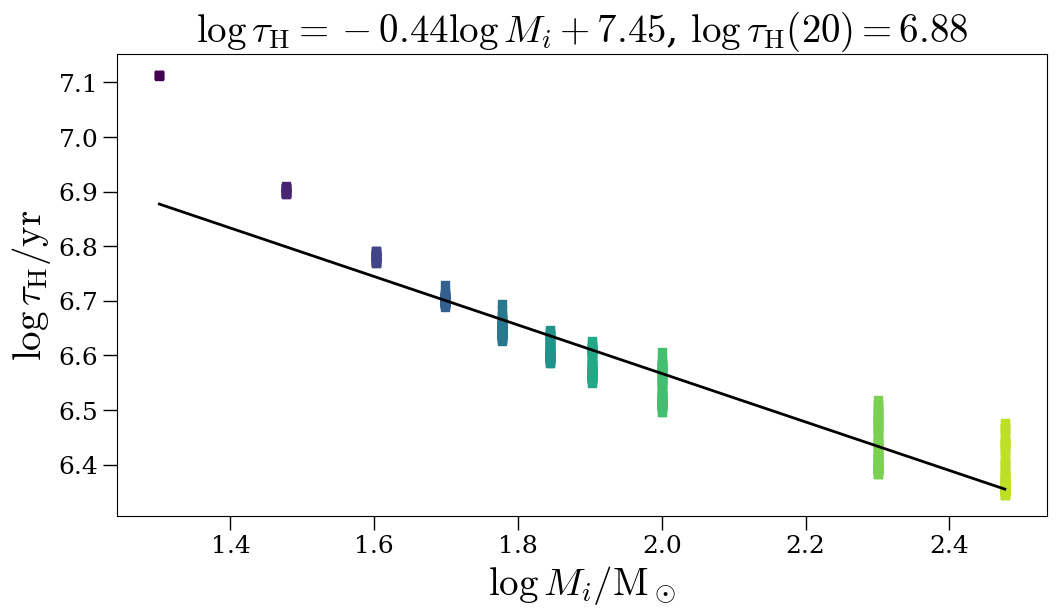

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
cmap = cm.viridis

X = []
Y =  []     
for z_key in h_lifetimes_dict.keys():
    mkeys = np.array(list(h_lifetimes_dict[z_key].keys()))
    mkeys = mkeys[np.argsort(mkeys.astype('float'))]
    for i, m in enumerate(mkeys):
        for p in h_lifetimes_dict[z_key][m].keys():
            if 'h_burn' not in h_lifetimes_dict[z_key][m][p].keys():
                continue
            h_burn_lt = h_lifetimes_dict[z_key][m][p]['h_burn']
            x = np.log10(float(m))
            y = np.log10(h_burn_lt)
            ax.scatter(x, y, marker='s', color=cmap(i/len(list(h_lifetimes_dict[z_key].keys()))))
            X.append(x)
            Y.append(y)
ax.set_xlabel('$\\log M_i/\\mathrm{M}_\odot$')
ax.set_ylabel('$\\log \\tau_\\mathrm{H}/\\mathrm{yr}$')

X = np.array(X)
Y = np.array(Y)
Y = Y[np.argsort(X)]
X = X[np.argsort(X)]
slope, norm, *_ = linregress(X, Y)
ax.plot(X, slope*X + norm, color='k', lw=2)
ax.set_title(f'$\log \\tau_\\mathrm{{H}} = {slope:.2f} \log M_i + {norm:.2f}$, $\\log\\tau_\\mathrm{{H}}(20)={slope*np.log10(20)+norm:.2f}$')

            

Text(0.5, 1.0, '$\\log \\tau_\\mathrm{He} = -0.32 \\log M_i + 6.06$, $\\log\\tau_\\mathrm{He}(20)=5.64$')

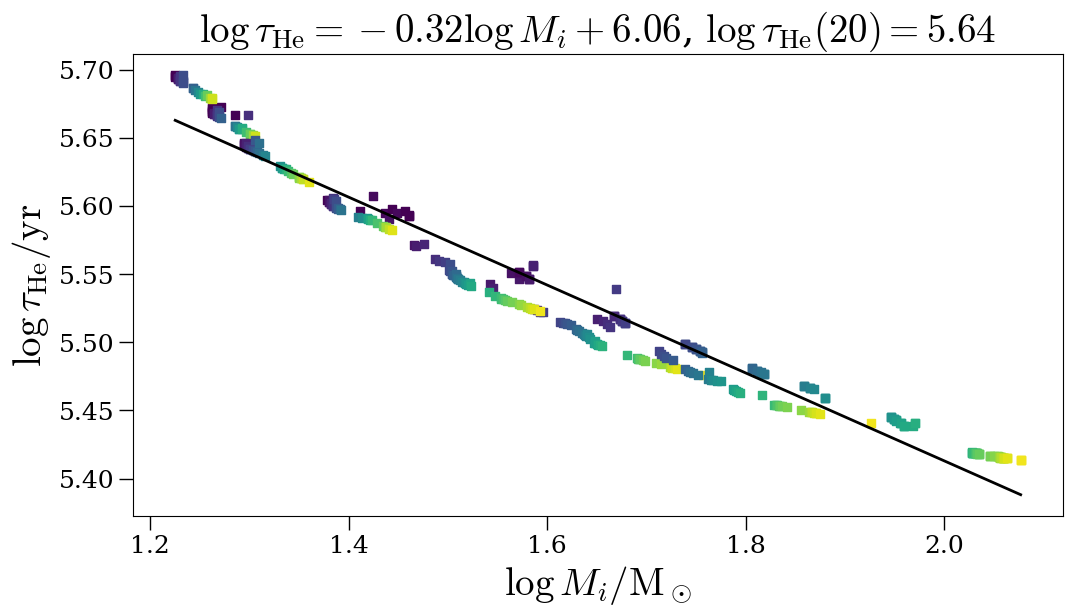

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
cmap = cm.viridis

X = []
Y =  []     
for z_key in he_lifetimes_dict.keys():
    mkeys = np.array(list(he_lifetimes_dict[z_key].keys()))
    mkeys = mkeys[np.argsort(mkeys.astype('float'))]
    for i, m in enumerate(mkeys):
        for p in he_lifetimes_dict[z_key][m].keys():
            if 'he_burn' not in he_lifetimes_dict[z_key][m][p].keys():
                continue
            he_burn_lt = he_lifetimes_dict[z_key][m][p]['he_burn']
            x = np.log10(float(m))
            y = np.log10(he_burn_lt)
            ax.scatter(x, y, marker='s', color=cmap(i/len(list(he_lifetimes_dict[z_key].keys()))))
            X.append(x)
            Y.append(y)
ax.set_xlabel('$\\log M_i/\\mathrm{M}_\odot$')
ax.set_ylabel('$\\log \\tau_\\mathrm{He}/\\mathrm{yr}$')

X = np.array(X)
Y = np.array(Y)
Y = Y[np.argsort(X)]
X = X[np.argsort(X)]
slope, norm, *_ = linregress(X, Y)
ax.plot(X, slope*X + norm, color='k', lw=2)
ax.set_title(f'$\log \\tau_\\mathrm{{He}} = {slope:.2f} \log M_i + {norm:.2f}$, $\\log\\tau_\\mathrm{{He}}(20)={-0.32*np.log10(20)+6.06:.2f}$')

            

In [116]:
X

array([], dtype=float64)

In [119]:
 wr_lifetimes_dict

{'0.1': {'70.0': {'0.40': {},
   '0.50': {},
   '0.60': {},
   '0.70': {},
   '0.80': {'wr': 1062676.8802560554},
   '0.90': {'wr': 1002592.2915488868},
   '1.00': {'wr': 934986.6714669582},
   '1.20': {'wr': 790159.7726209289},
   '1.40': {'wr': 731719.8883639718},
   '1.60': {},
   '1.80': {},
   '2.00': {},
   '2.30': {},
   '2.60': {},
   '3.00': {},
   '4.00': {}},
  '60.0': {'0.40': {},
   '0.50': {},
   '0.60': {},
   '0.70': {'wr': 1276866.810097944},
   '0.80': {'wr': 1246298.2661637012},
   '0.90': {'wr': 1212659.8853839883},
   '1.00': {'wr': 1175688.5874852804},
   '1.20': {'wr': 1084462.8986709737},
   '1.40': {},
   '1.60': {},
   '1.80': {},
   '2.00': {},
   '2.30': {},
   '2.60': {},
   '3.00': {},
   '4.00': {}},
  '100.0': {'0.40': {},
   '0.50': {},
   '0.60': {},
   '0.70': {},
   '0.80': {},
   '0.90': {'wr': 990394.5891949977},
   '1.00': {'wr': 997990.1588938246},
   '1.20': {'wr': 1004981.5597504317},
   '1.40': {'wr': 1015954.4317970932},
   '1.60': {'wr': 103

(5.6, 6.433871488856451)

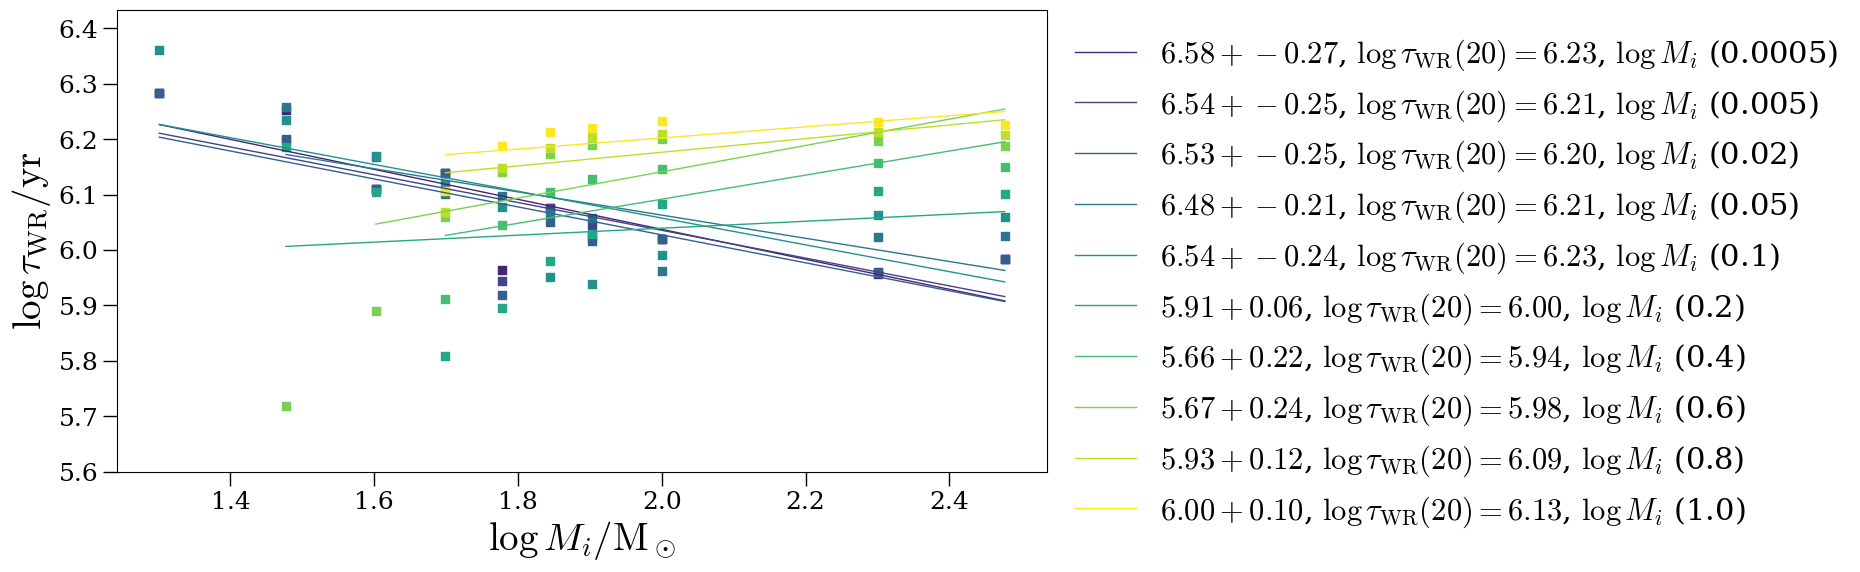

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
cmap = cm.viridis

 
sorted_zkeys = sorted(list(wr_lifetimes_dict.keys()))
for z_key in sorted_zkeys:
    X = []
    Y =  []   
    c = cmap((z_keys.index(z_key)+1)/len(z_keys))
    mkeys = np.array(list(wr_lifetimes_dict[z_key].keys()))
    mkeys = mkeys[np.argsort(mkeys.astype('float'))]
    for i, m in enumerate(mkeys):
        x = []
        y = []
        for p in wr_lifetimes_dict[z_key][m].keys():
            if 'wr' not in wr_lifetimes_dict[z_key][m][p].keys():
                continue
            wr_lt = wr_lifetimes_dict[z_key][m][p]['wr']   
            x.append(np.log10(float(m)))
            y.append(np.log10(wr_lt))
        x = np.mean(x)
        y = np.mean(y)
        if y >= 5.8:
            X.append(x)
            Y.append(y)
        ax.scatter(x, y, marker='s', color=c)
    X = np.array(X)
    Y = np.array(Y)
    Y = Y[np.argsort(X)]
    X = X[np.argsort(X)]
    Y = Y[~np.isnan(X)]
    X = X[~np.isnan(X)]
    slope, norm, *_ = linregress(X, Y)
    ax.plot(X, slope*X + norm, color=c, lw=1, label=f'${norm:.2f}+{slope:.2f}$, $\\log\\tau_\\mathrm{{WR}}(20)={slope*np.log10(20)+norm:.2f}$, $\\log M_i$ ({z_key})')
ax.set_xlabel('$\\log M_i/\\mathrm{M}_\odot$')
ax.set_ylabel('$\\log \\tau_\\mathrm{WR}/\\mathrm{yr}$')



ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylim(5.6)

Text(0.5, 1.0, '$\\log M_{WR} = 0.64 \\log M_i + 0.51$, $\\log M_{WR}(20)=1.34$')

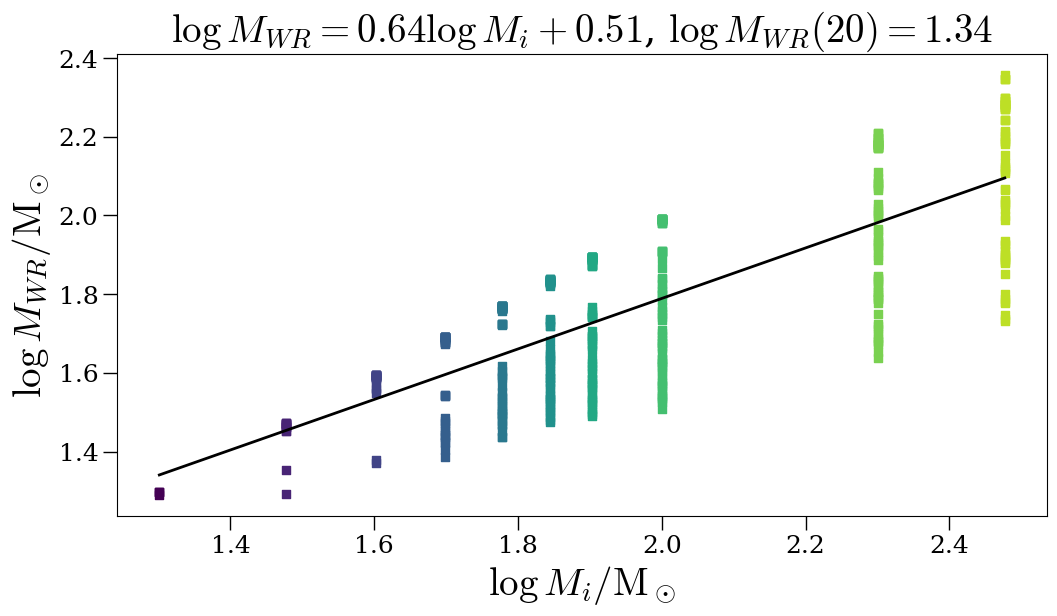

In [95]:
fig, ax = plt.subplots(figsize=(12, 6))

X = []
Y =  []
for z_key in wr_mis_dict.keys():
    mkeys = np.array(list(wr_mis_dict[z_key].keys()))
    mkeys = mkeys[np.argsort(mkeys.astype('float'))]
    for i, m in enumerate(mkeys):
        for p in wr_mis_dict[z_key][m].keys():
            if 'm_wr_i' not in wr_mis_dict[z_key][m][p].keys():
                continue
            m_wr_i = wr_mis_dict[z_key][m][p]['m_wr_i']
            x = np.log10(float(m))
            y = np.log10(m_wr_i)
            ax.scatter(x, y, marker='s', color=cmap(i/len(list(wr_mis_dict[z_key].keys()))))
            X.append(x)
            Y.append(y)
ax.set_xlabel('$\\log M_i/\\mathrm{M}_\odot$')
ax.set_ylabel('$\\log M_{WR}/\\mathrm{M}_\odot$')
X = np.array(X)
Y = np.array(Y)
Y = Y[np.argsort(X)]
X = X[np.argsort(X)]
slope, norm, *_ = linregress(X, Y)
ax.plot(X, slope*X + norm, color='k', lw=2)
ax.set_title(f'$\log M_{{WR}} = {slope:.2f} \log M_i + {norm:.2f}$, $\\log M_{{WR}}(20)={slope*np.log10(20)+norm:.2f}$')


Text(0.5, 1.0, '$\\log  M_\\mathrm{ZAMS}= 0.95 \\log M_{WR} + 0.30$')

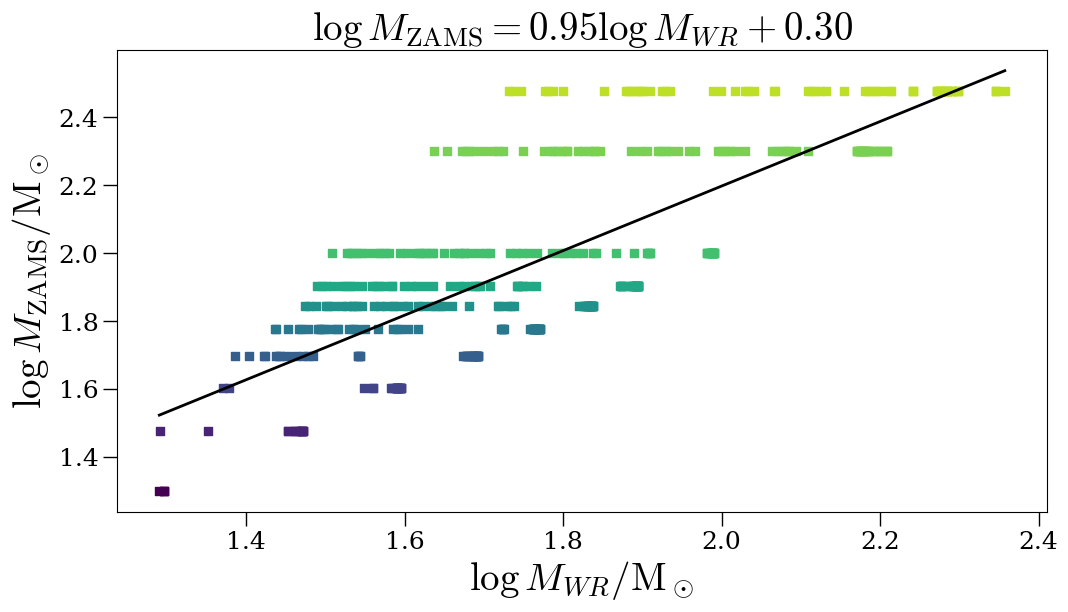

In [98]:
fig, ax = plt.subplots(figsize=(12, 6))

X = []
Y =  []
for z_key in wr_mis_dict.keys():
    mkeys = np.array(list(wr_mis_dict[z_key].keys()))
    mkeys = mkeys[np.argsort(mkeys.astype('float'))]
    for i, m in enumerate(mkeys):
        for p in wr_mis_dict[z_key][m].keys():
            if 'm_wr_i' not in wr_mis_dict[z_key][m][p].keys():
                continue
            m_wr_i = wr_mis_dict[z_key][m][p]['m_wr_i']
            y = np.log10(float(m))
            x = np.log10(m_wr_i)
            ax.scatter(x, y, marker='s', color=cmap(i/len(list(wr_mis_dict[z_key].keys()))))
            X.append(x)
            Y.append(y)
ax.set_ylabel('$\\log M_\\mathrm{ZAMS}/\\mathrm{M}_\odot$')
ax.set_xlabel('$\\log M_{WR}/\\mathrm{M}_\odot$')
X = np.array(X)
Y = np.array(Y)
Y = Y[np.argsort(X)]
X = X[np.argsort(X)]
slope, norm, *_ = linregress(X, Y)
ax.plot(X, slope*X + norm, color='k', lw=2)
ax.set_title(f'$\log  M_\\mathrm{{ZAMS}}= {slope:.2f} \log M_{{WR}} + {norm:.2f}$')


In [109]:
list(wr_mis_dicts.keys())

NameError: name 'wr_mis_dicts' is not defined

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


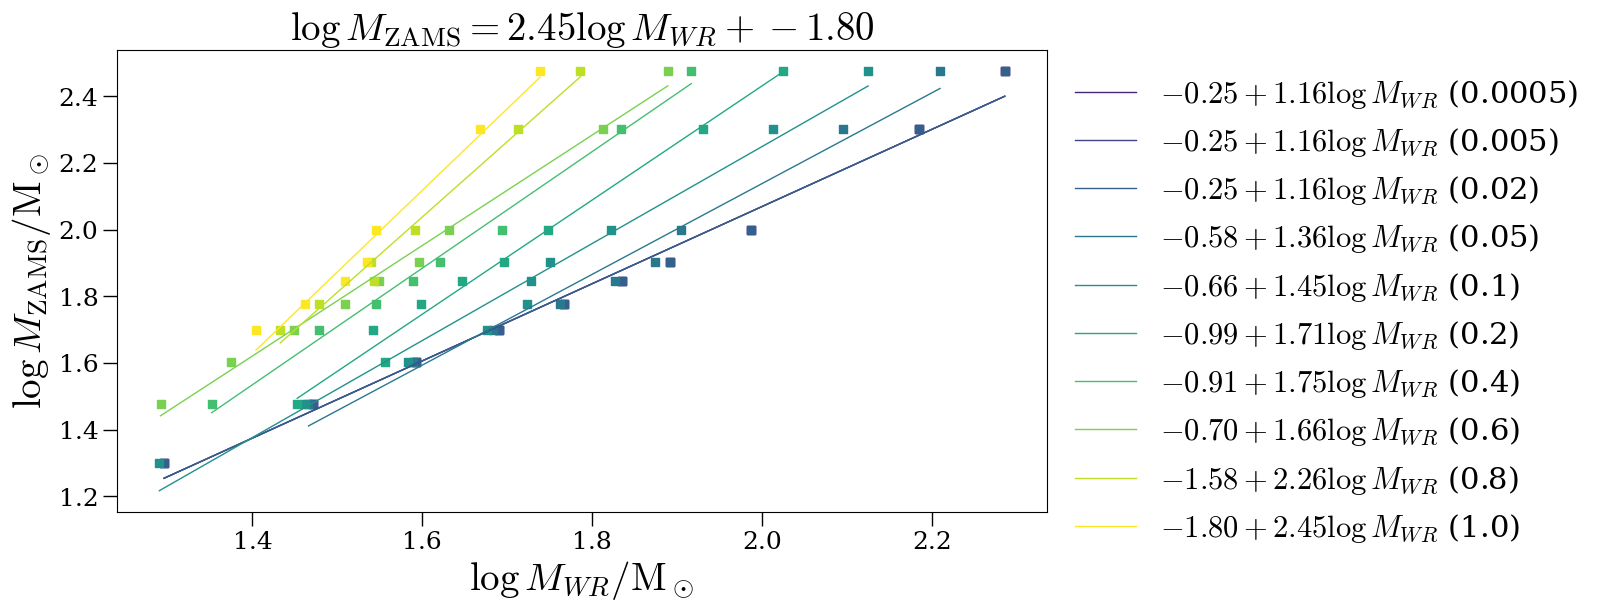

In [113]:
fig, ax = plt.subplots(figsize=(12, 6))

sorted_zkeys = sorted(list(wr_mis_dict.keys()))
for z_key in sorted_zkeys:
    c = cmap((z_keys.index(z_key)+1)/len(z_keys))
    mkeys = np.array(list(wr_mis_dict[z_key].keys()))
    mkeys = mkeys[np.argsort(mkeys.astype('float'))]
    X = []
    Y =  []
    for i, m in enumerate(mkeys):
        y = []
        x = []
        for p in wr_mis_dict[z_key][m].keys():
            if 'm_wr_i' not in wr_mis_dict[z_key][m][p].keys():
                continue
            m_wr_i = wr_mis_dict[z_key][m][p]['m_wr_i']
            y.append(np.log10(float(m)))
            x.append(np.log10(m_wr_i))
        x = np.mean(x)
        y = np.mean(y)
        ax.scatter(x, y, marker='s', color=c)
        X.append(x)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    Y = Y[np.argsort(X)]
    X = X[np.argsort(X)]
    Y = Y[~np.isnan(X)]
    X = X[~np.isnan(X)]
    slope, norm, *_ = linregress(X, Y)
    ax.plot(X, slope*X + norm, color=c, lw=1, label=f'${norm:.2f}+{slope:.2f}\\log M_{{WR}}$ ({z_key})')
ax.set_ylabel('$\\log M_\\mathrm{ZAMS}/\\mathrm{M}_\odot$')
ax.set_xlabel('$\\log M_{WR}/\\mathrm{M}_\odot$')

ax.set_title(f'$\log  M_\\mathrm{{ZAMS}}= {slope:.2f} \log M_{{WR}} + {norm:.2f}$')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

In [134]:
10.**2.2

158.48931924611142

In [ ]:
def dmwr